In [7]:
import certifi
import json
import numpy as np
import urllib3
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
%matplotlib inline

"finished"

'finished'

In [8]:
url = "https://interaktiv.morgenpost.de/data/corona/history.compact.json"

http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())

r = http.request('GET', url)

if (r.status == 200):
    data = json.loads(r.data.decode('utf-8'))

r.status

200

In [15]:
#region_id = "hu"
region_id = "de"
#region_id = "de.be"

ma_period = 7
# Streeck, H., Schulte, B., Kümmerer, B. M., Richter, E., Höller, T., Fuhrmann, C., ... & Hartmann, G. (2020).
# Infection fatality rate of SARS-CoV2 in a super-spreading event in Germany. Nature communications, 11(1), 1-12.
theoretical_mortality = 0.0035

region = next(filter(lambda e: e[0] == region_id, data))
datasize = len(region[10])
population_100k = region[6] / 100000.0

# Select and sanitize data
# current day data is usually wonky so we drop it
infections = np.array(region[10])[:-1] / population_100k
recoveries = np.array(region[11])[:-1] / population_100k
deaths = np.array(region[12])[:-1] / population_100k

cumulative_cases = np.cumsum(infections)
cumulative_recoveries = np.cumsum(recoveries)
cumulative_deaths = np.cumsum(deaths)

cumulative_mortality_rate = (cumulative_deaths / cumulative_cases) * 100.0
mortality_inferred_cumulative_cases = cumulative_deaths / theoretical_mortality

# Rolling sum
increments = infections - recoveries - deaths
active = np.cumsum(increments)

# Moving averages
def ma(series):
    lead_in = np.zeros(ma_period - 1, dtype=np.float)
    moving_avgs = np.convolve(series, np.ones(ma_period), 'valid') / ma_period
    return np.concatenate((lead_in, moving_avgs))

infections_ma = ma(infections)
recoveries_ma = ma(recoveries)
deaths_ma = ma(deaths)

# Notable weekly incidence rates
weekly_incidence_hi = 100.0 / 7.0
weekly_incidence_hi_label = 'weekly incidence of 100 / 100k'
weekly_incidence_lo = 50.0 / 7.0
weekly_incidence_lo_label = 'weekly incidence of 50 / 100k'

# Some matplotlib date stuff
today = mdate.date2num(datetime.date.today())
x = np.arange(today-(datasize-1), today)

month_formatter = mdate.DateFormatter('%Y.%m')
day_formatter = mdate.DateFormatter('%m.%d')

month_locator = mdate.MonthLocator()
day_locator = mdate.DayLocator()
week_locator = mdate.WeekdayLocator(byweekday=mdate.SUNDAY)

# Some utilities for labeling
def place_along_interval(a, b, loc):
    l = b-a
    return a + l * loc

def horizontal_line_with_label(axis, y, color, linestyle, label, label_pos):
    ymin, ymax = axis.get_ylim()
    if (y < ymin or y > ymax):
        return
    label_x_pos = place_along_interval(*(axis.get_xlim()), label_pos)
    axis.axhline(y, color=color, linestyle=linestyle)
    t = axis.text(label_x_pos, y, label, verticalalignment='center')
    t.set_bbox(dict(facecolor=axis.get_facecolor(), linewidth=0, alpha=0.6))

region[2] + ", pop. " + str(region[6])

'Deutschland, pop. 83166711'

'plotting data'

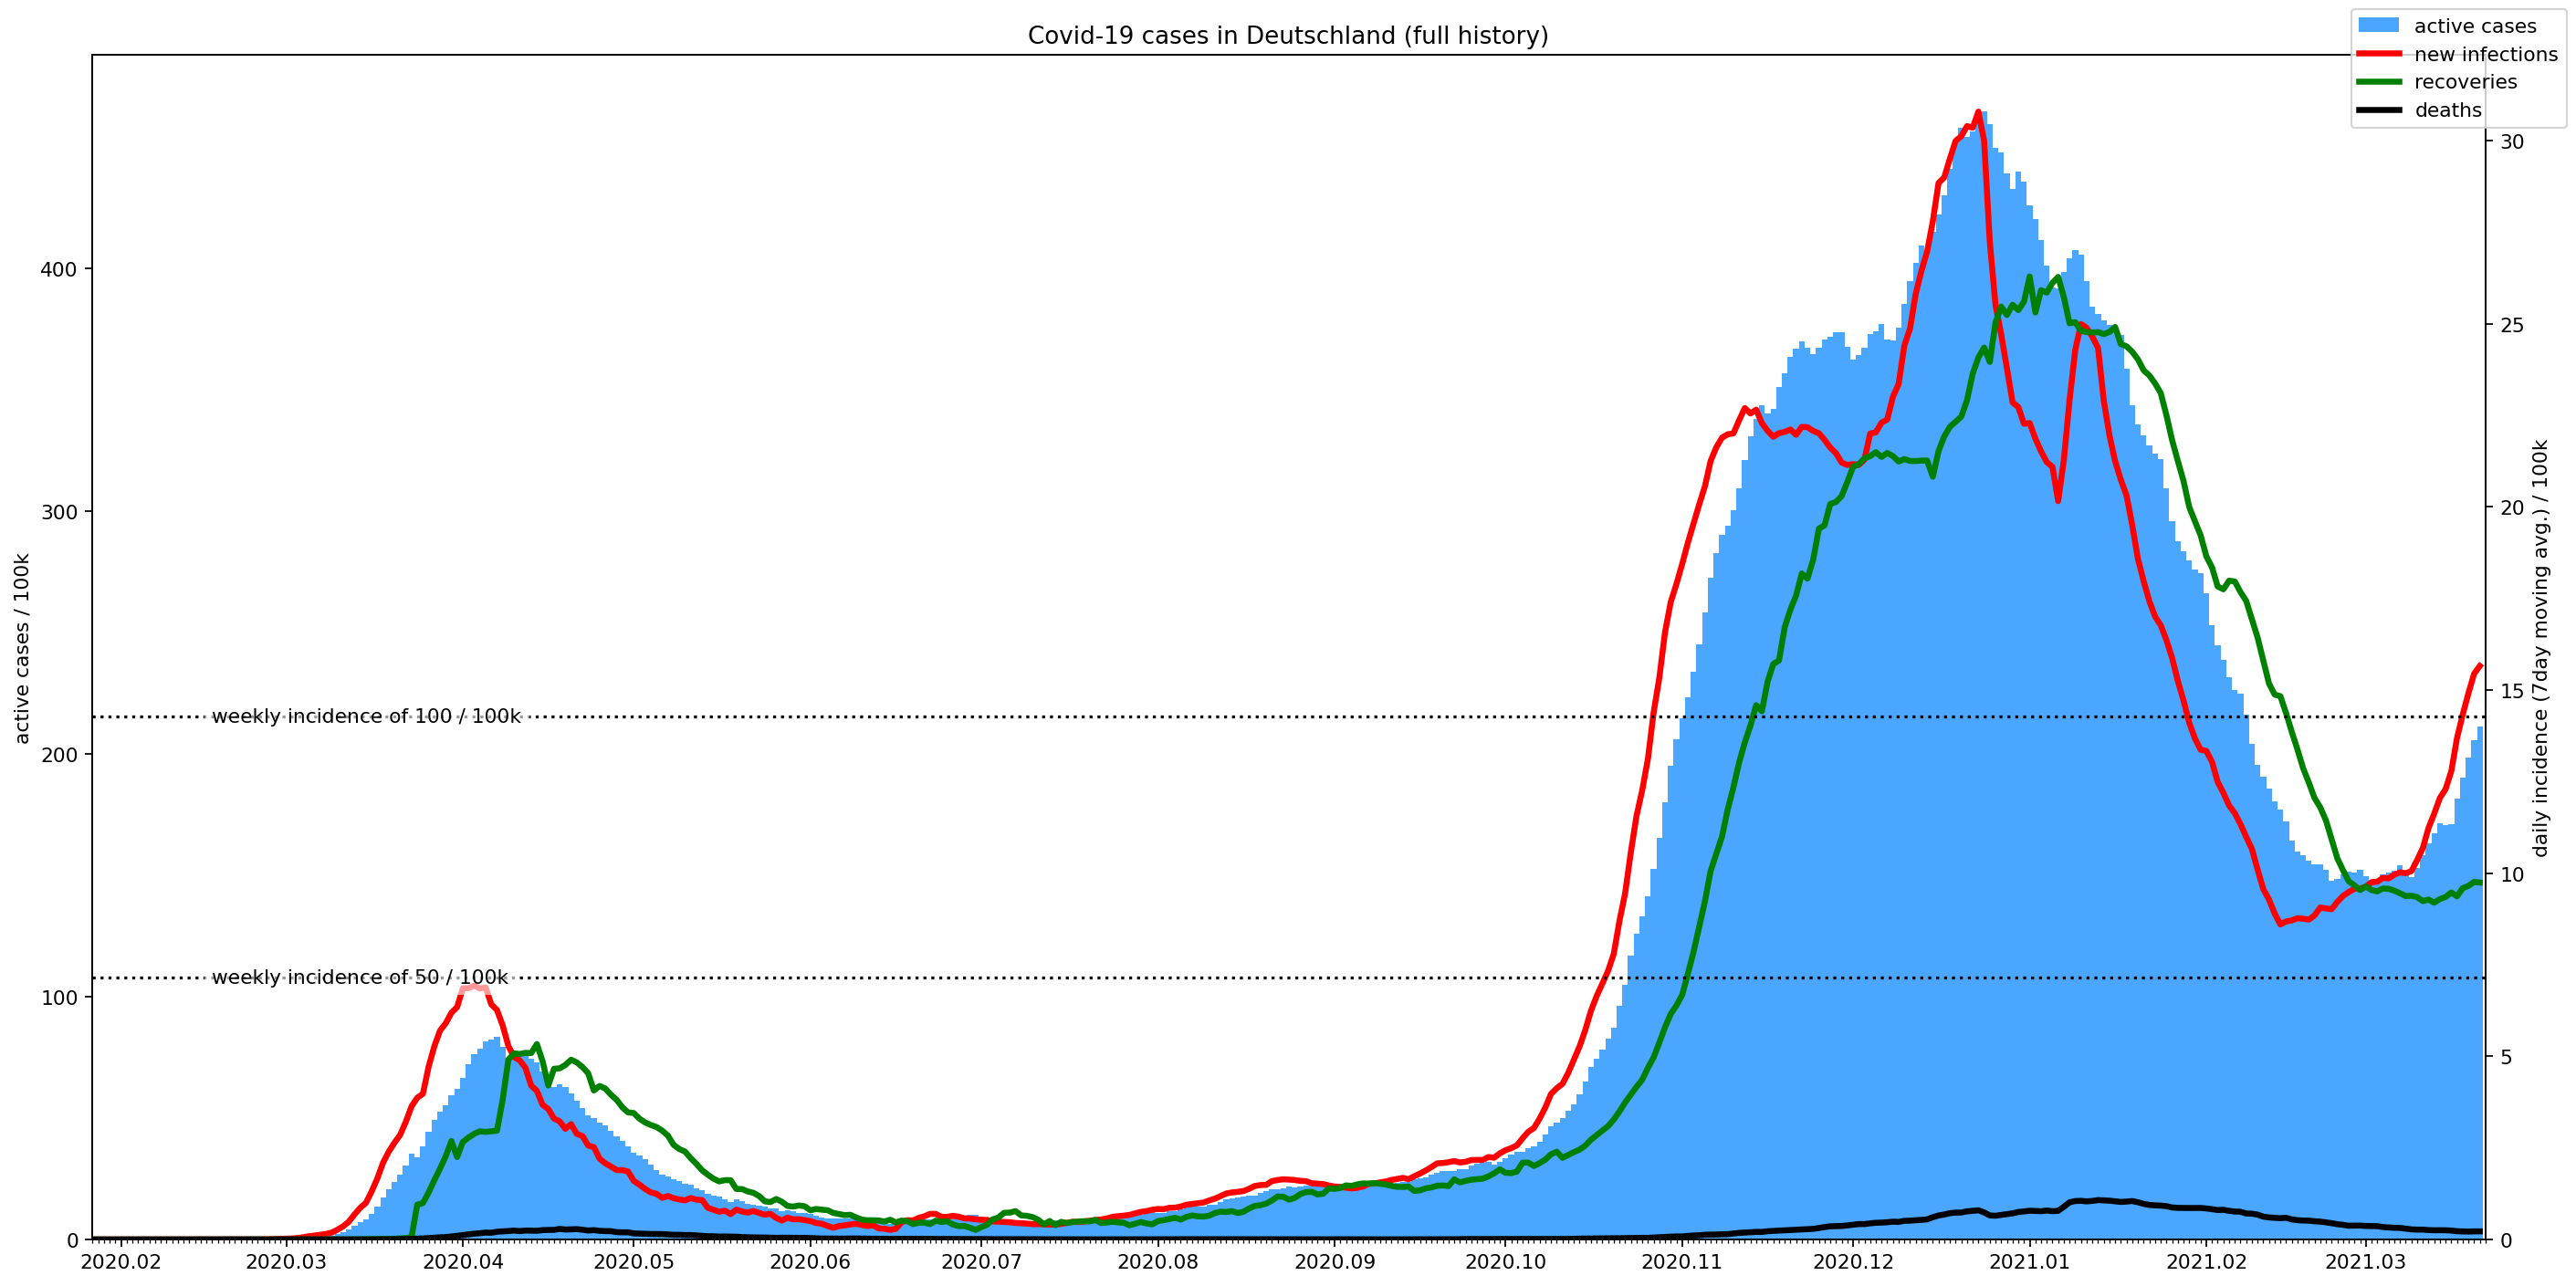

In [16]:
fig1, ax11 = plt.subplots(figsize=(18,9), dpi=157)

ax11.set_title("Covid-19 cases in " + region[2] + " (full history)")

ax11.xaxis.set_major_locator(month_locator)
ax11.xaxis.set_major_formatter(month_formatter)
ax11.xaxis.set_minor_locator(day_locator)

ax11.set_xlim(x[0], today)
ax11.set_ylabel('active cases / 100k')
ax11.bar(x, active, color='dodgerblue', alpha=0.8, label='active cases', width=1, align='center')
ax11.set_ylim(ymin=0)

ax12 = ax11.twinx()
ax12.set_ylabel('daily incidence (' +str(ma_period) + 'day moving avg.) / 100k')
ax12.plot(x, infections_ma, color='red', label='new infections', linewidth=3)
ax12.plot(x, recoveries_ma, color='green', label='recoveries', linewidth=3)
ax12.plot(x, deaths_ma, color='black', label='deaths', linewidth=3)
ax12.set_ylim(ymin=0)
horizontal_line_with_label(ax12, weekly_incidence_hi, color='black', linestyle=':', label=weekly_incidence_hi_label, label_pos=0.05)
horizontal_line_with_label(ax12, weekly_incidence_lo, color='black', linestyle=':', label=weekly_incidence_lo_label, label_pos=0.05)

fig1.tight_layout()
fig1.legend()

"plotting data"

'plotting data'

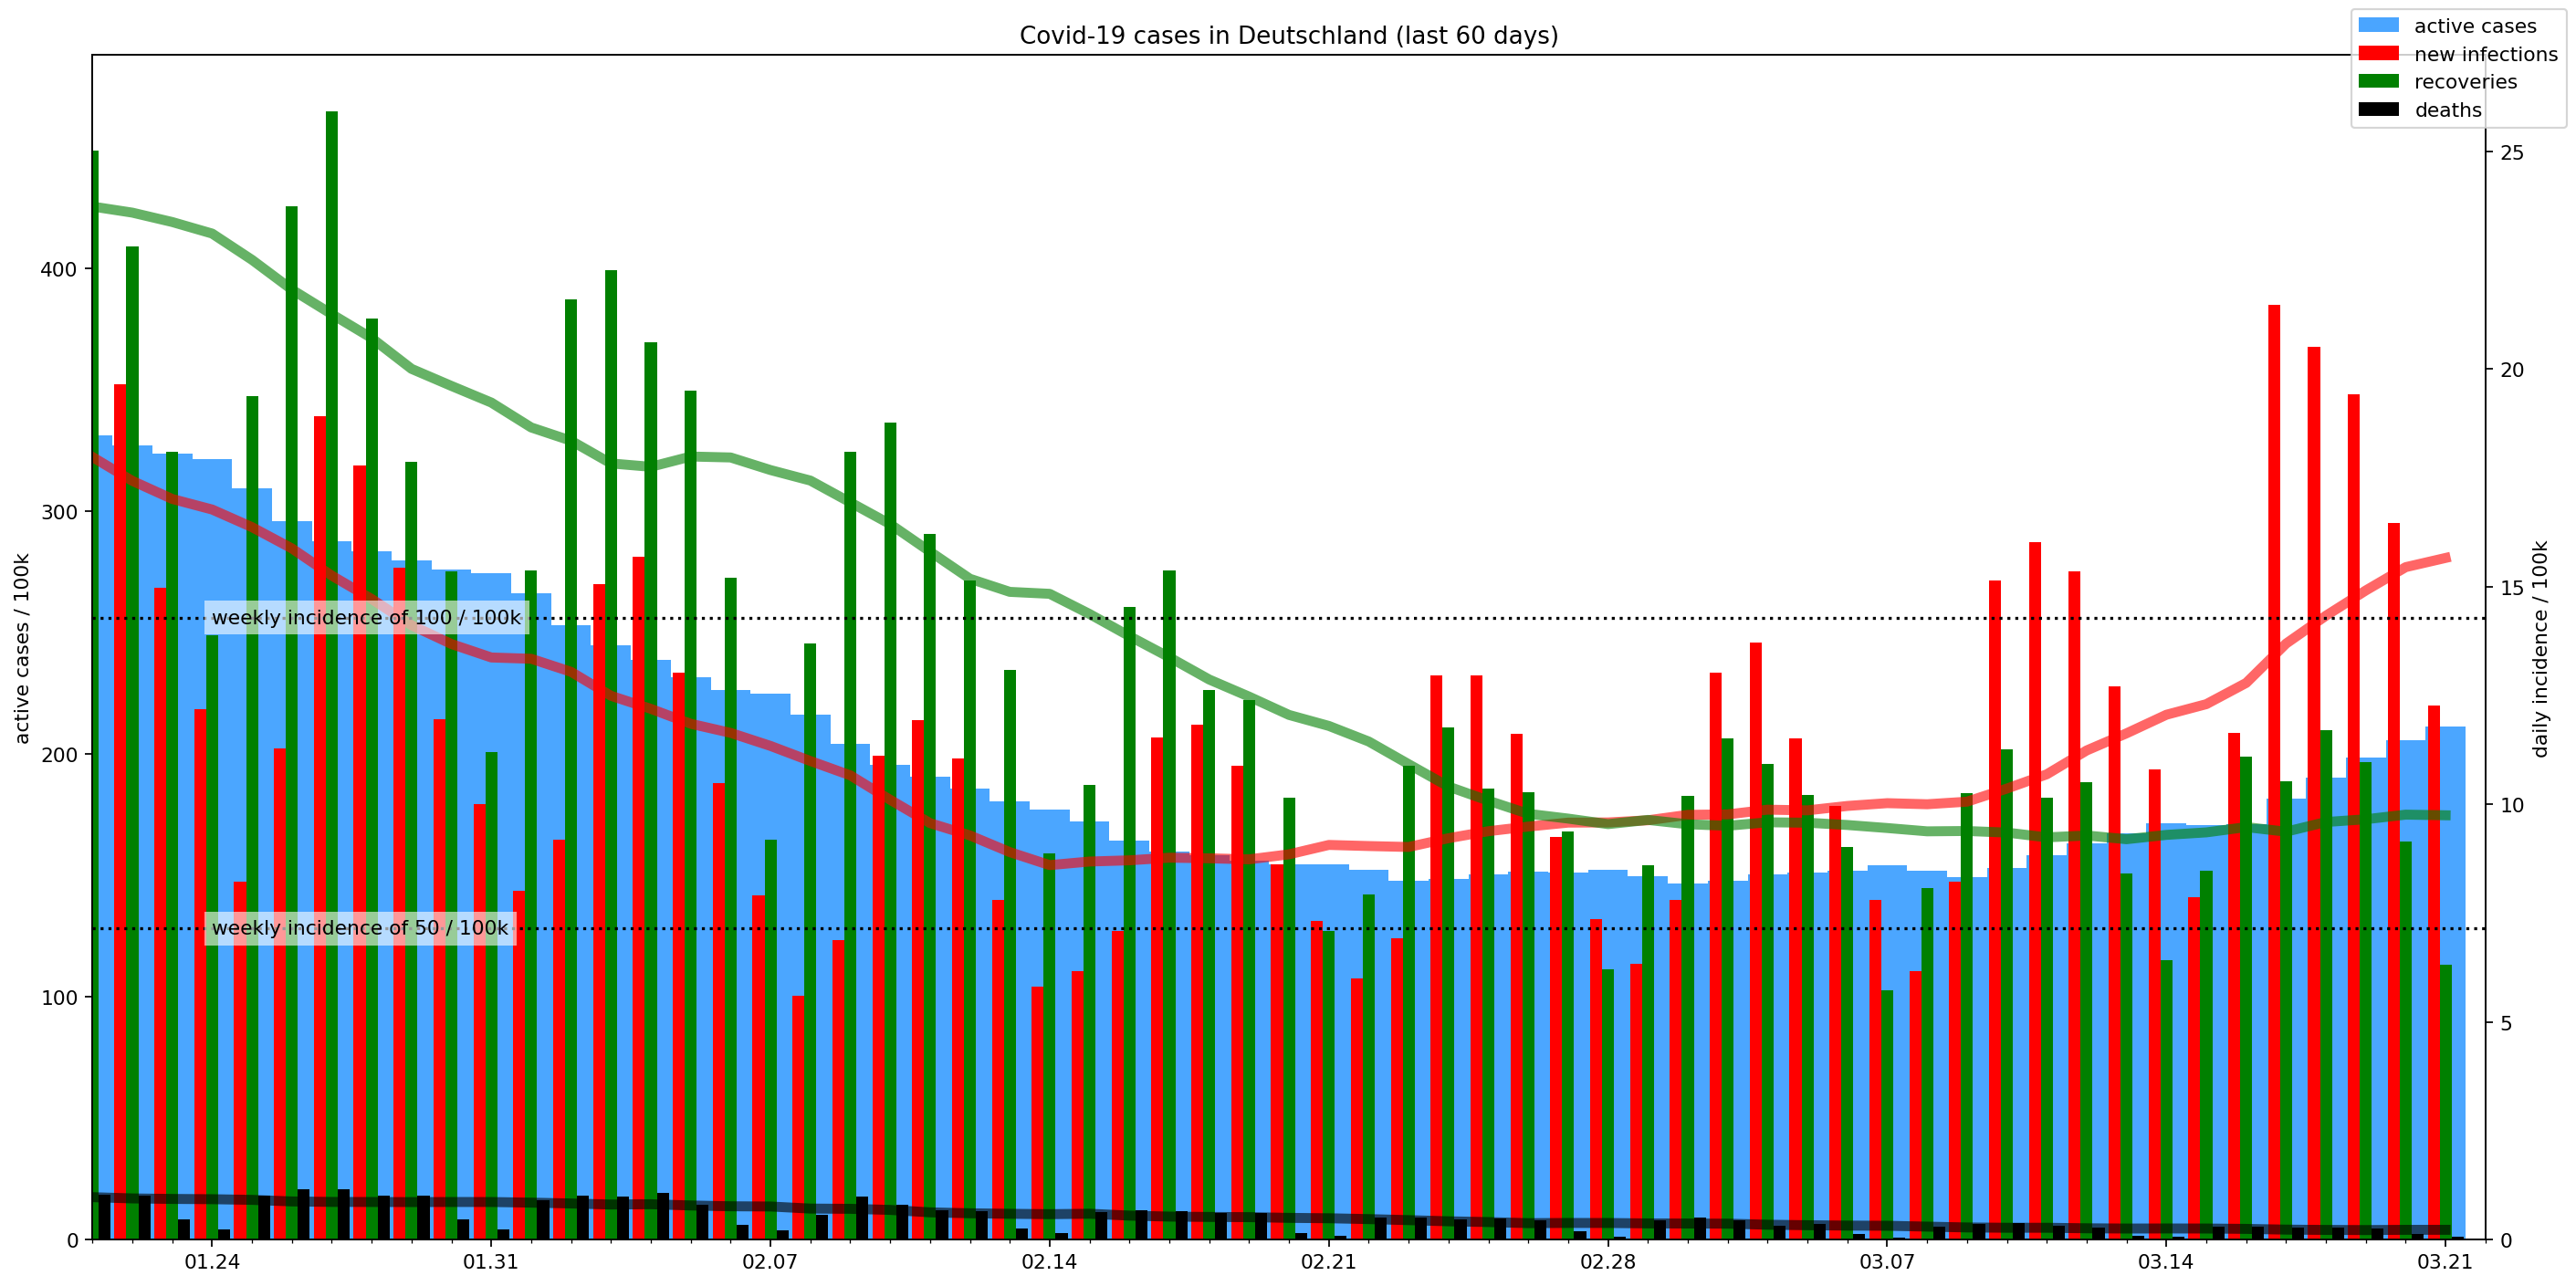

In [17]:
fig2, ax21 = plt.subplots(figsize=(18,9), dpi=157)

ax21.set_title("Covid-19 cases in " + region[2] + " (last 60 days)")

ax21.xaxis.set_major_locator(week_locator)
ax21.xaxis.set_major_formatter(day_formatter)
ax21.xaxis.set_minor_locator(day_locator)

ax21.set_xlim(x[-60], today)
ax21.set_ylabel('active cases / 100k')
ax21.bar(x, active, color='dodgerblue', label='active cases', width=1, alpha=0.8, align='center')
ax21.set_ylim(ymin=0)

width = 0.3
ax22 = ax21.twinx()
ax22.set_ylabel('daily incidence / 100k')
ax22.bar(x[-60:] - width, infections[-60:], width, color='red', label='new infections')
ax22.bar(x[-60:], recoveries[-60:], width, color='green', label='recoveries')
ax22.bar(x[-60:] + width, deaths[-60:], width, color='black', label='deaths')
ax22.plot(x[-60:], infections_ma[-60:], color='red', alpha=0.6, linewidth=5)
ax22.plot(x[-60:], recoveries_ma[-60:], color='green', alpha=0.6, linewidth=5)
ax22.plot(x[-60:], deaths_ma[-60:], color='black', alpha=0.6, linewidth=5)
ax22.set_ylim(ymin=0)
horizontal_line_with_label(ax22, weekly_incidence_hi, color='black', linestyle=':', label=weekly_incidence_hi_label, label_pos=0.05)
horizontal_line_with_label(ax22, weekly_incidence_lo, color='black', linestyle=':', label=weekly_incidence_lo_label, label_pos=0.05)

fig2.tight_layout()
fig2.legend()

"plotting data"

'plotting data'

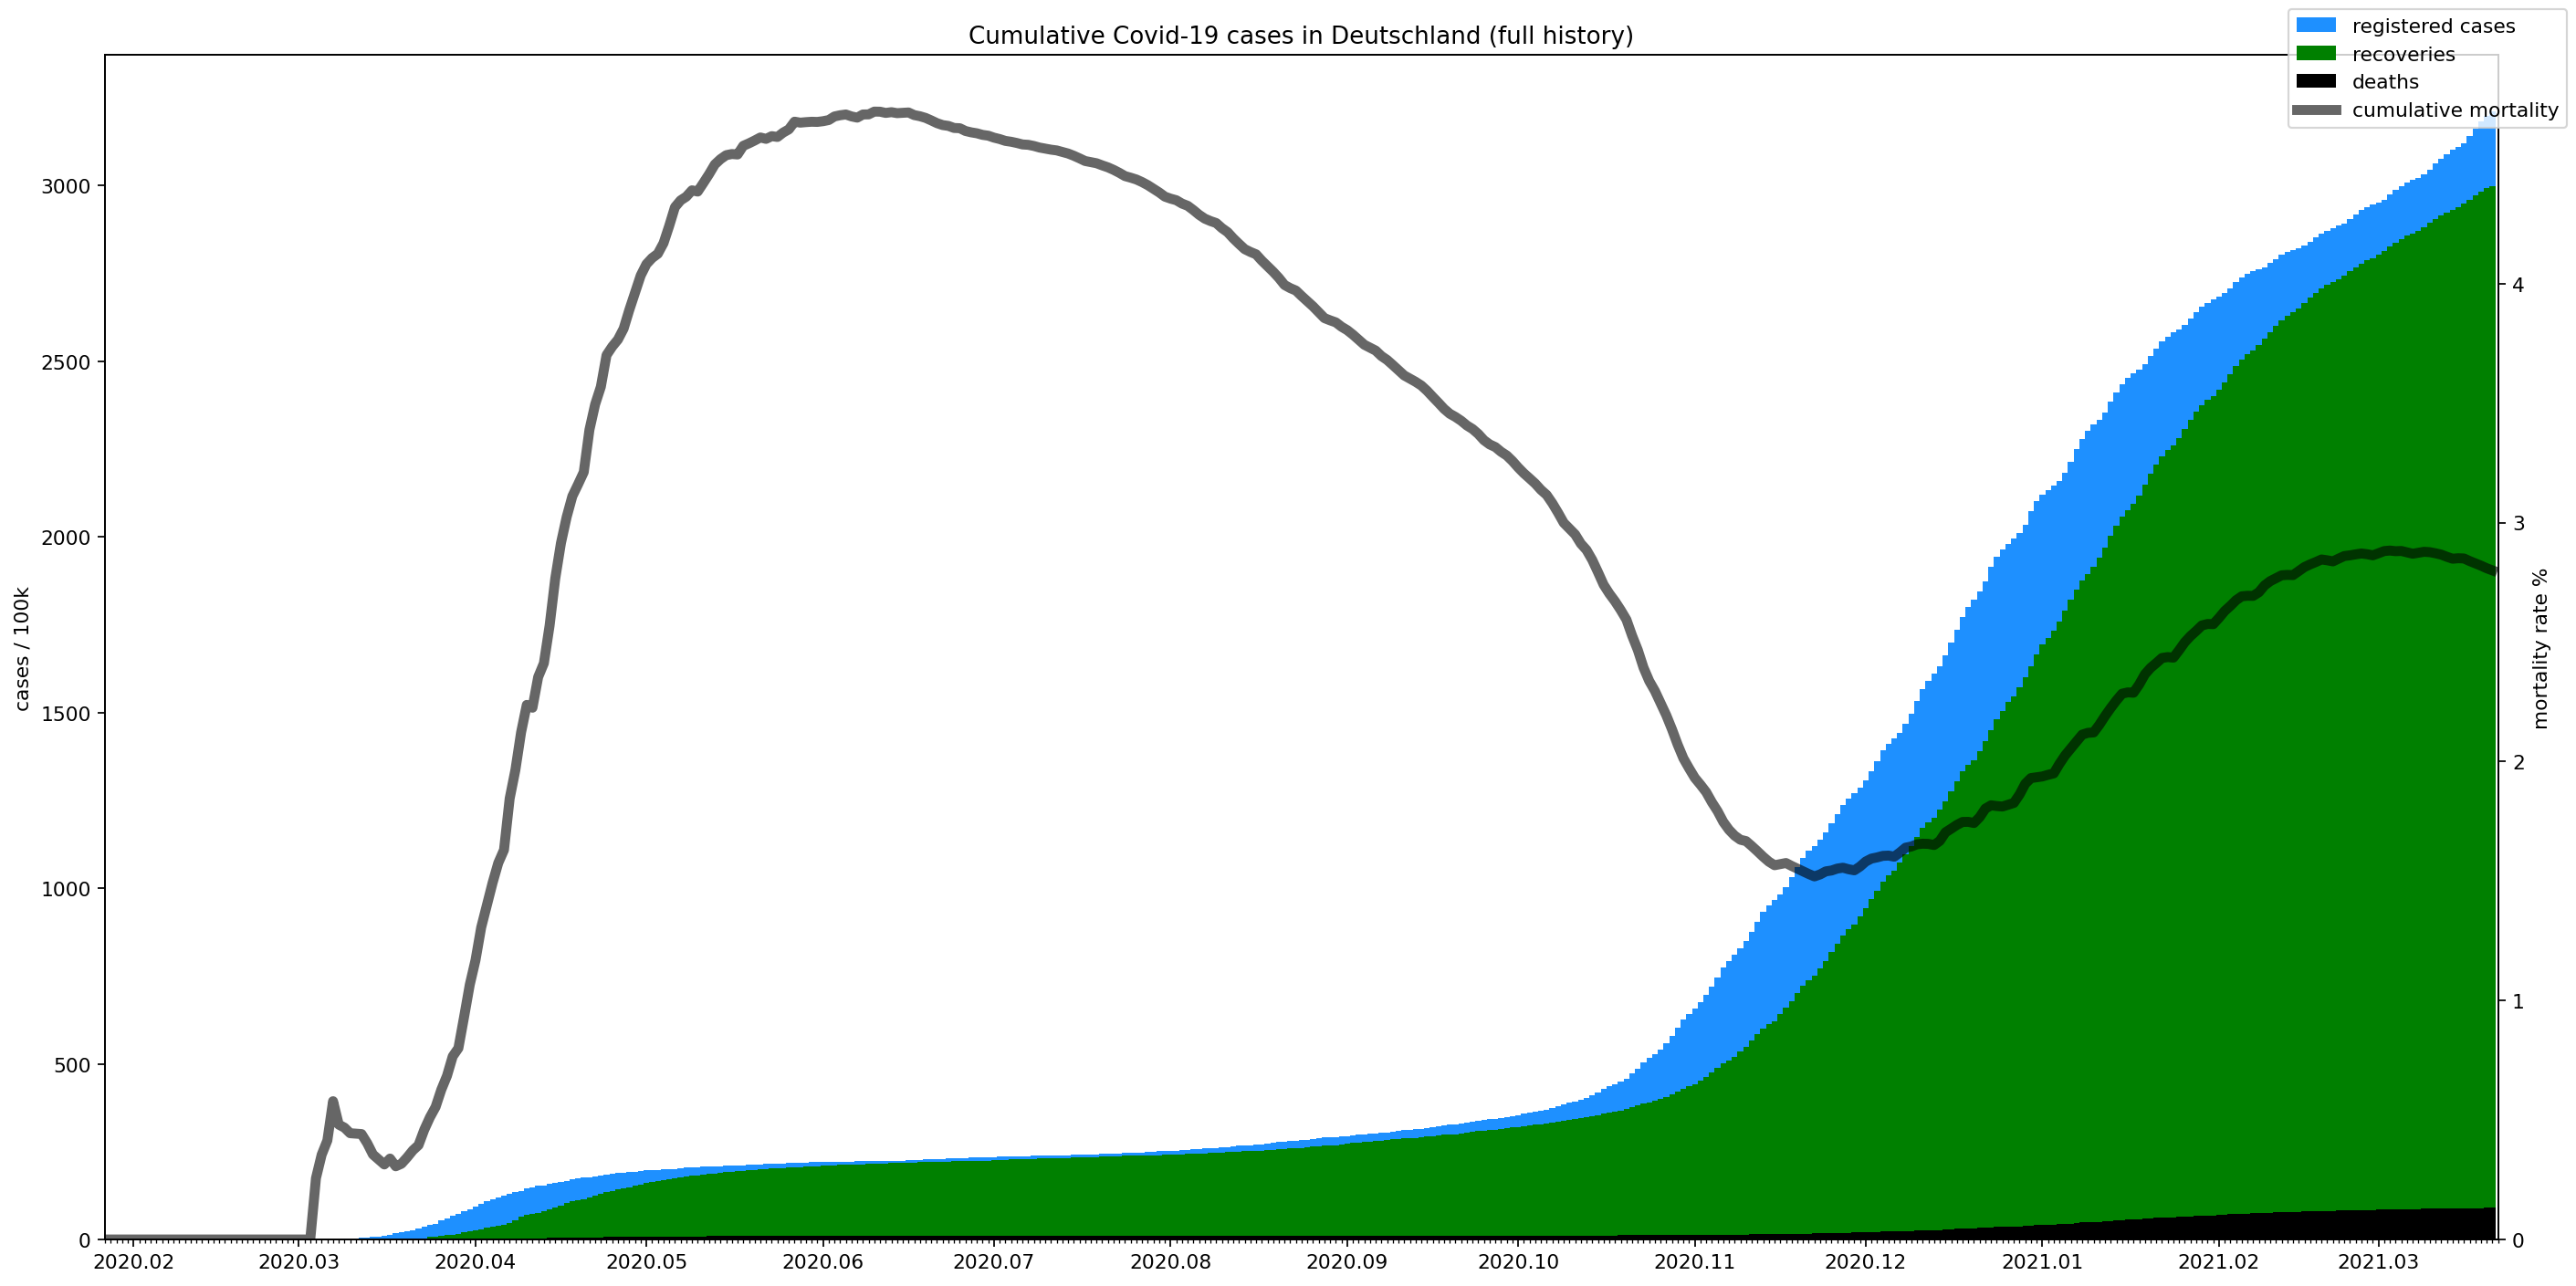

In [19]:
fig3, ax31 = plt.subplots(figsize=(18,9), dpi=157)

ax31.set_title("Cumulative Covid-19 cases in " + region[2] + " (full history)")

ax31.xaxis.set_major_locator(month_locator)
ax31.xaxis.set_major_formatter(month_formatter)
ax31.xaxis.set_minor_locator(day_locator)

ax31.set_xlim(x[0], today)
ax31.set_ylabel('cases / 100k')
#ax31.bar(x, mortality_inferred_cumulative_cases, color='yellow', label='cum. cases inferred from deaths', width=1, align='center')
ax31.bar(x, cumulative_cases, color='dodgerblue', label='registered cases', width=1, align='center')
ax31.bar(x, cumulative_recoveries, bottom=cumulative_deaths, color='green', label='recoveries', width=1, align='center')
ax31.bar(x, cumulative_deaths, color='black', label='deaths', width=1, align='center')
ax31.set_ylim(ymin=0)

ax32 = ax31.twinx()
ax32.set_ylabel('mortality rate %')
ax32.plot(x, cumulative_mortality_rate, label='cumulative mortality', color='black', alpha=0.6, linewidth=5)
ax32.set_ylim(ymin=0)

fig3.tight_layout()
fig3.legend()

"plotting data"